In [12]:
import os
import sys
import numpy                              as np
import pandas                             as pd

import matplotlib
from matplotlib                           import pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

import tensorflow                         as tf
from tensorflow                           import keras
from tensorflow                           import train
from tensorflow.keras                     import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras                     import regularizers
from tensorflow.keras                     import optimizers
from tensorflow.keras                     import losses
from tensorflow.keras                     import callbacks
from tensorflow.python.ops                import array_ops
from sklearn.model_selection              import train_test_split

In [27]:
ROMNetFldr      = WORKSPACE_PATH + '/ROMNet/romnet/'
PathToRunFld    = ROMNetFldr     + '/../0React_5PC_BNN1/'
PathToParamsFld = PathToRunFld   + '/Params/'
PCADirTrain     = WORKSPACE_PATH + '/ROMNet/Data_10_0DReact_EASY/'
PCADirTest      = WORKSPACE_PATH + '/ROMNet/Data_10_0DReact_EASY_Test/'
PCADir          = PCADirTest

NRed            = 20

TrunkVars       = ['t']
BranchVars      = []
for iRed in range(NRed):
    BranchVars.append('PC_'+str(iRed+1))
TotVars         = TrunkVars + BranchVars

In [28]:
FileName  = PCADir + '/orig_data/yCleaned.csv'
yMatData  = pd.read_csv(FileName, header=0)
VarNames  = list(yMatData.columns)
yMatOrig  = yMatData.to_numpy()
tOrig     = yMatOrig[:,0]


# FileName  = PCADirTest + '/pc_data/PC.csv.' + str(NRed)
# yMat_pca  = pd.read_csv(FileName, header=0).to_numpy()

In [29]:
FileName        = PCADir + '/DeepONet_'+str(NRed)+'/Input.csv'
Input           = pd.read_csv(FileName, header=0)
Input['tOrig']  = Input['t']
Input['t']      = np.log10(Input['t'].to_numpy(np.float64))


FileName        = PCADir + '/DeepONet_'+str(NRed)+'/Output.csv'
Output          = pd.read_csv(FileName, header=0)
Output['tOrig'] = Output['t']
Output['t']     = np.log10(Output['t'].to_numpy(np.float64))

<ipython-input-29-03a43a273b52>:4: RuntimeWarning: divide by zero encountered in log10
  Input['t']      = np.log10(Input['t'].to_numpy(np.float64))
<ipython-input-29-03a43a273b52>:10: RuntimeWarning: divide by zero encountered in log10
  Output['t']     = np.log10(Output['t'].to_numpy(np.float64))


In [30]:
FileName = PCADirTrain + '/pca_'+str(NRed)+'/A.csv'
A        = pd.read_csv(FileName, header=None).to_numpy()

FileName = PCADirTrain + '/pca_'+str(NRed)+'/C.csv'
C        = np.squeeze(pd.read_csv(FileName, header=None).to_numpy())

FileName = PCADirTrain + '/pca_'+str(NRed)+'/D.csv'
D        = np.squeeze(pd.read_csv(FileName, header=None).to_numpy())

yMat_    = (Output[BranchVars].to_numpy().dot(A))*D + C

iVar =  1


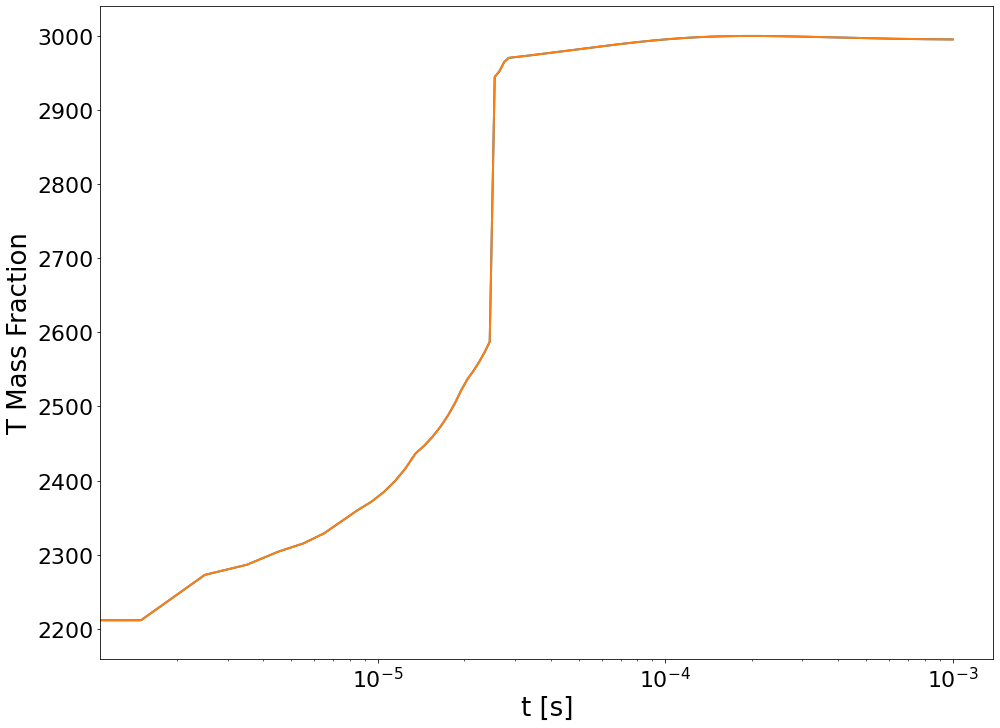

In [32]:
VarOI = 'T'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break

fig = plt.figure(figsize=(16, 12))

plt.plot(yMatData['# t'], yMatData[VarOI])
plt.plot(yMatData['# t'], yMat_[:,iVar-1])
plt.xlabel('t [s]')
plt.ylabel(VarOI+' Mass Fraction')
plt.xscale('log')

iVar =  3


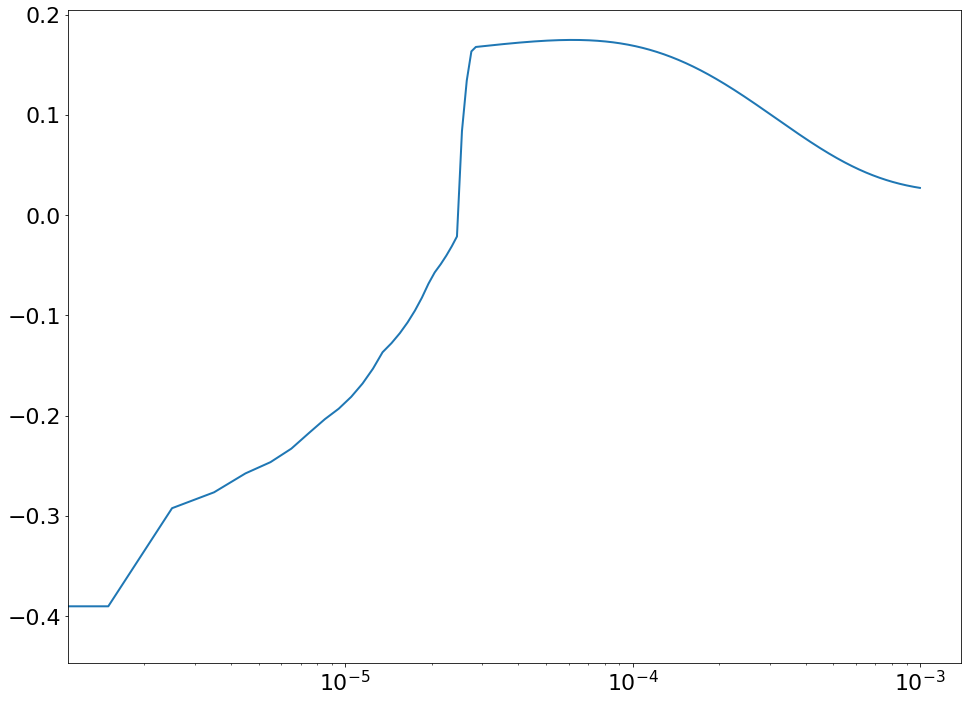

In [7]:
VarOI = 'PC_3'
for iVar in range(1,len(TotVars)):
    if (TotVars[iVar] == VarOI):
        print('iVar = ', iVar)
        break

fig = plt.figure(figsize=(16, 12))

plt.plot(Output['tOrig'], Output[VarOI])
plt.xscale('log')

In [8]:
Output['t']

0          -inf
1     -5.823909
2     -5.602060
3     -5.455932
4     -5.346787
         ...   
995   -3.001959
996   -3.001523
997   -3.001087
998   -3.000652
999   -3.000217
Name: t, Length: 1000, dtype: float64

In [9]:
ModelFile = PathToRunFld + '/NNModel'
Model     = keras.models.load_model(ModelFile)
Model.summary()

MCFile         = PathToParamsFld + "/ModelCheckpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(MCFile)
latest         = train.latest_checkpoint(checkpoint_dir)
Model.load_weights(latest)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
tf.split (TFOpLambda)           [(None, 5), (None, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 5)            11          tf.split[0][0]                   
__________________________________________________________________________________________________
Branch0_HL1 (Dense)             (None, 64)           384         normalization_1[0][0]            
______________________________________________________________________________________________

In [10]:
yMat_sum = np.zeros((Input.shape[0], len(BranchVars)))
yMat_sqr = np.zeros((Input.shape[0], len(BranchVars)))

NSamples = 100

for iSample in range(NSamples):
    yMat_pca_ = Model.predict(Input[TrunkVars+BranchVars])    
    
    yMat_sum += yMat_pca_
    yMat_sqr += yMat_pca_**2
    
yMat_mean = yMat_sum/NSamples
yMat_std  = np.sqrt( yMat_sqr/NSamples - yMat_mean**2 )
yMat_p1   = yMat_mean + 1.*yMat_std
yMat_m1   = yMat_mean - 1.*yMat_std
yMat_p2   = yMat_mean + 2.*yMat_std
yMat_m2   = yMat_mean - 2.*yMat_std
yMat_p3   = yMat_mean + 3.*yMat_std
yMat_m3   = yMat_mean - 3.*yMat_std

iVar =  1


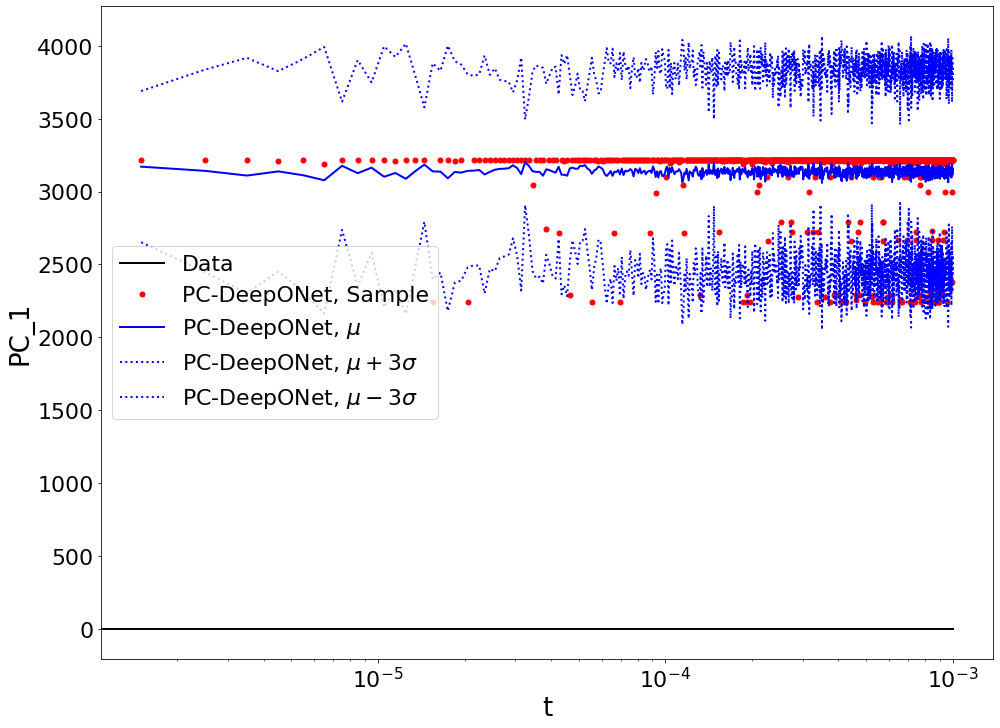

In [19]:
PCNames = TrunkVars+BranchVars

VarOI = 'PC_1'
for iVar in range(1,len(PCNames)):
    if (PCNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break

fig = plt.figure(figsize=(16, 12))

plt.plot(Input['tOrig'], Output['tOrig'],  'k-', label='Data')

plt.plot(Input['tOrig'], yMat_[:,iVar-1],    'ro', markersize=5, label='PC-DeepONet, Sample')

plt.plot(Input['tOrig'], yMat_mean[:,iVar-1], 'b-', label=r'PC-DeepONet, $\mu$')
plt.plot(Input['tOrig'], yMat_p3[:,iVar-1],   'b:', label=r'PC-DeepONet, $\mu+3\sigma$')
plt.plot(Input['tOrig'], yMat_m3[:,iVar-1],   'b:', label=r'PC-DeepONet, $\mu-3\sigma$')

plt.xlabel('t')
plt.ylabel(VarOI)
plt.xscale('log')
plt.legend()
plt.show()

In [20]:
yMat_pca_

array([[        nan,         nan,         nan,         nan,         nan],
       [14.34935   , -0.6870979 ,  0.78533876,  1.123942  , -1.5401313 ],
       [14.350258  , -0.68710494,  0.78533876,  1.1241803 , -1.5401313 ],
       ...,
       [14.360577  , -0.6870979 ,  0.78533876,  1.1241803 , -1.5401317 ],
       [14.465443  ,  1.6170349 ,  0.78533876,  1.1241801 , -1.5401317 ],
       [14.360584  , -0.6870979 ,  0.78533876,  1.1240635 , -0.0812086 ]],
      dtype=float32)

In [13]:
yMat_sum = np.zeros((Input.shape[0], yMatOrig.shape[1]-1))
yMat_sqr = np.zeros((Input.shape[0], yMatOrig.shape[1]-1))

NSamples = 100

for iSample in range(NSamples):
    yMat_pca_ = Model.predict(Input[TrunkVars+BranchVars])    
    
    yMat_     = (yMat_pca_.dot(A))*D + C
    yMat_sum += yMat_
    yMat_sqr += yMat_**2
    
yMat_mean = yMat_sum/NSamples
yMat_std  = np.sqrt( yMat_sqr/NSamples - yMat_mean**2 )
yMat_p1   = yMat_mean + 1.*yMat_std
yMat_m1   = yMat_mean - 1.*yMat_std
yMat_p2   = yMat_mean + 2.*yMat_std
yMat_m2   = yMat_mean - 2.*yMat_std
yMat_p3   = yMat_mean + 3.*yMat_std
yMat_m3   = yMat_mean - 3.*yMat_std

In [14]:
yMat_mean

array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 3.17058135e+03,  4.64105930e-03,  2.13996256e-03, ...,
        -1.10418178e-06, -4.43402796e-05, -1.18329883e-04],
       [ 3.14187232e+03,  4.32088743e-03,  1.95019171e-03, ...,
        -1.19782257e-06, -5.12334243e-05, -1.61790952e-04],
       ...,
       [ 3.15744382e+03,  4.56649111e-03,  2.07026127e-03, ...,
        -1.15633634e-06, -4.74059553e-05, -1.35235700e-04],
       [ 3.14701000e+03,  4.34628772e-03,  2.07533760e-03, ...,
        -1.14506673e-06, -5.00841387e-05, -1.53836521e-04],
       [ 3.14287985e+03,  4.70647560e-03,  1.99439141e-03, ...,
        -1.08551619e-06, -4.12291302e-05, -9.72672795e-05]])

In [15]:
# Ny = yMat_pca.shape[1]
# for iy in range(Ny):
#     fig = plt.figure(figsize=(16, 12))
    
#     plt.plot(10**tPred, yMat_pca_[:,iy], 'ro', label='Noisy Data')
    
#     plt.plot(10**tPred, yMat_mean[:,iy], 'b-')
#     plt.plot(10**tPred, yMat_p3[:,iy],   'b-')
#     plt.plot(10**tPred, yMat_m3[:,iy],   'b-')
    
#     plt.plot(tOrig, yMat_pca[:,iy], 'k-', label='Original Data')

#     plt.xlabel('t')
#     plt.ylabel('PC'+str(iy+1))
#     plt.xscale('log')
#     plt.show()
#     plt.legend()
#     iy+=1

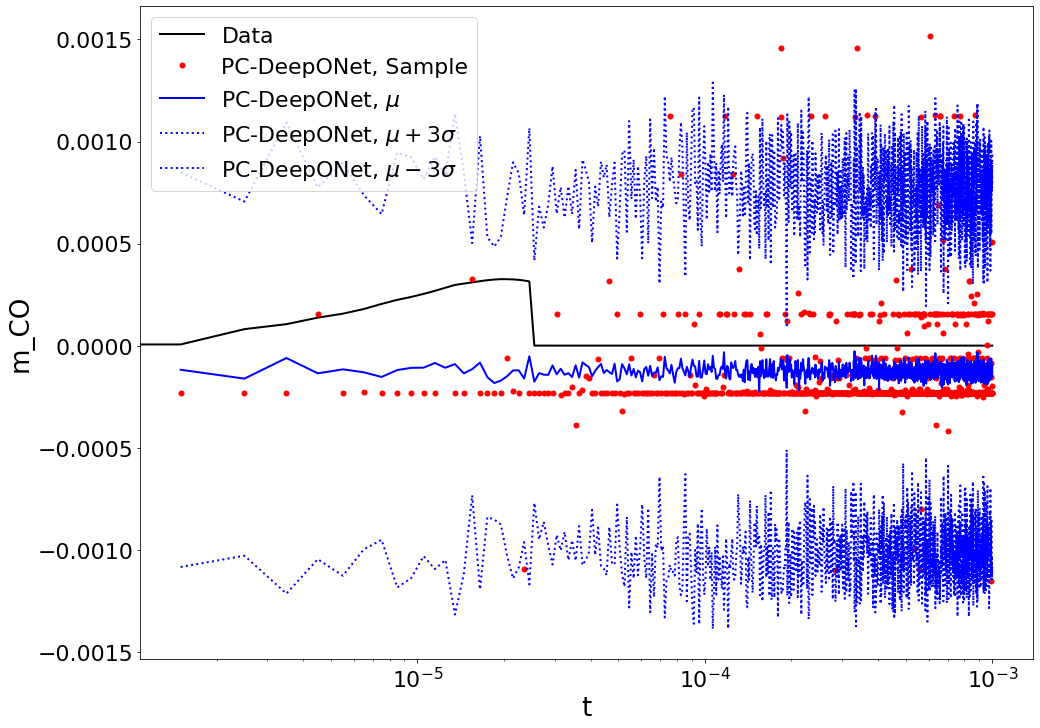

In [16]:
VarOI = 'm_CO'
for iVar in range(1,len(VarNames)):
    if (VarNames[iVar] == VarOI):
        print('iVar = ', iVar)
        break

fig = plt.figure(figsize=(16, 12))

plt.plot(yMatOrig[:,0], yMatOrig[:,iVar],  'k-', label='Data')

plt.plot(Input['tOrig'], yMat_[:,iVar-1],    'ro', markersize=5, label='PC-DeepONet, Sample')

plt.plot(Input['tOrig'], yMat_mean[:,iVar-1], 'b-', label=r'PC-DeepONet, $\mu$')
plt.plot(Input['tOrig'], yMat_p3[:,iVar-1],   'b:', label=r'PC-DeepONet, $\mu+3\sigma$')
plt.plot(Input['tOrig'], yMat_m3[:,iVar-1],   'b:', label=r'PC-DeepONet, $\mu-3\sigma$')

plt.xlabel('t')
plt.ylabel(VarOI)
plt.xscale('log')
plt.legend()
plt.show()

In [17]:
iTot=0
for iReac in range(14):
    for iS in range(iReac+1,15):
        print('From '+str(iS)+' to '+str(iReac))
        iTot+=1

From 1 to 0
From 2 to 0
From 3 to 0
From 4 to 0
From 5 to 0
From 6 to 0
From 7 to 0
From 8 to 0
From 9 to 0
From 10 to 0
From 11 to 0
From 12 to 0
From 13 to 0
From 14 to 0
From 2 to 1
From 3 to 1
From 4 to 1
From 5 to 1
From 6 to 1
From 7 to 1
From 8 to 1
From 9 to 1
From 10 to 1
From 11 to 1
From 12 to 1
From 13 to 1
From 14 to 1
From 3 to 2
From 4 to 2
From 5 to 2
From 6 to 2
From 7 to 2
From 8 to 2
From 9 to 2
From 10 to 2
From 11 to 2
From 12 to 2
From 13 to 2
From 14 to 2
From 4 to 3
From 5 to 3
From 6 to 3
From 7 to 3
From 8 to 3
From 9 to 3
From 10 to 3
From 11 to 3
From 12 to 3
From 13 to 3
From 14 to 3
From 5 to 4
From 6 to 4
From 7 to 4
From 8 to 4
From 9 to 4
From 10 to 4
From 11 to 4
From 12 to 4
From 13 to 4
From 14 to 4
From 6 to 5
From 7 to 5
From 8 to 5
From 9 to 5
From 10 to 5
From 11 to 5
From 12 to 5
From 13 to 5
From 14 to 5
From 7 to 6
From 8 to 6
From 9 to 6
From 10 to 6
From 11 to 6
From 12 to 6
From 13 to 6
From 14 to 6
From 8 to 7
From 9 to 7
From 10 to 7
From

In [18]:
iTot

105